# Pre-Analysis of data
Here we join the files to be used in the analysis phase and then we experiment with the parameters for the classifiers to obtain the parametric values for the models.
First, we import all the packages

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table,join,hstack
from scipy.stats import binned_statistic
import astropy.units as u
import seaborn as sns
import pandas as pd
from collections import Counter
import matplotlib.lines as mlines
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

Additionally, we include some shortcuts to simplify some code

In [3]:
### User shortcuts 
def Perc75(array):
    """75th Percentile"""
    return(np.percentile(array,75))
def Perc25(array):
    """25th Percentile"""
    return(np.percentile(array,25))
def CreateTableCIG(PaTable,Samp,TypeAGN):
    """Calculate the Matthwes, Cohen, F1-macro and accuracy of the results"""
    for jj in ['SKIRTOR','Fritz','S37','F37']:
        MCC=matthews_corrcoef(PaTable.loc[jj][Samp],PaTable.loc[jj][TypeAGN])
        F1s=f1_score(PaTable.loc[jj][Samp],PaTable.loc[jj][TypeAGN],average='macro')
        Acc=accuracy_score(PaTable.loc[jj][Samp],PaTable.loc[jj][TypeAGN])
        print(jj,round(MCC,3),round(F1s,3),round(Acc,3))
def CreateTableClas(PaTable,Samp,TypeAGN):
    """Calculate the Matthwes, Cohen, F1-macro and accuracy of the results from the Classifiers"""
    for jj in ['SKIRTOR','Fritz','S37','F37']:
        X=PaTable.loc[jj][Samp]
        y=PaTable.loc[jj][TypeAGN]
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        le = preprocessing.LabelEncoder()
        le.fit(y)
        x_train_encode = preprocessing.robust_scale(x_train)
        x_test_encode = preprocessing.robust_scale(x_test)
        y_train_encode = le.transform(y_train).reshape(-1, 1).ravel()
        y_test_encode = le.transform(y_test).reshape(-1, 1).ravel()
        for iclf,Clasi in enumerate([clf_rf,clf_xg]):## This classifiers need to be defined before use
            print(['RandomForest','XGBoost'][iclf])
            Clasi.fit(x_train_encode, y_train_encode)
            MCC=matthews_corrcoef(y_test_encode,Clasi.predict(x_test_encode))
            F1s=f1_score(y_test_encode,Clasi.predict(x_test_encode),average='macro')
            Acc=accuracy_score(y_test_encode,Clasi.predict(x_test_encode))
            print(jj,round(MCC,3),round(F1s,3),round(Acc,3))
            result = permutation_importance(Clasi, x_test_encode, y_test_encode, n_repeats=20,
                                random_state=42, n_jobs=-1)
            sorted_idx = result.importances_mean.argsort()
            print(ManualCols[sorted_idx][-4:],np.mean(result.importances[sorted_idx],axis=1)[-4:])

def SelT1orT2(TableP):
    """Select Seyferts 1 and 2 in both VCV and CDS"""
    Selc1=np.logical_and(TableP['otype_txt']=='Sy1',TableP['Sp']=='S1')
    Selc2=np.logical_and(TableP['otype_txt']=='Sy2',TableP['Sp']=='S2')
    SelcSey=np.logical_or(Selc1,Selc2)
    return(TableP[SelcSey])

## Join all clean results

We read the results from the models we are going to use 

In [4]:
ModelS=Table.read('CIGALEOutputs/Cleanresults_SK.fits',format='fits')
ModelF=Table.read('CIGALEOutputs/Cleanresults_Fr.fits',format='fits')

ModelS37=Table.read('CIGALEOutputs/Cleanresults_SK37.fits',format='fits')
ModelF37=Table.read('CIGALEOutputs/Cleanresults_Fr37.fits',format='fits')

We also read the original database of galaxies to use the information for the classification

In [5]:
TV=Table.read('VCV_TAP_otype.txt',format='ascii')
TV.rename_column('main_id','id') ## Renamed to then join with the same id

We join this clean tables with the catalog

In [6]:
STVClean=join(TV,ModelS,keys='id')
FTVClean=join(TV,ModelF,keys='id')
STVClean37=join(TV,ModelS37,keys='id')
FTVClean37=join(TV,ModelF37,keys='id')

We send all the table to pandas and then concatenate to have an unique table

In [7]:
SPandas=STVClean.to_pandas()
FPandas=FTVClean.to_pandas()
SPandas37=STVClean37.to_pandas()
FPandas37=FTVClean37.to_pandas()
SFPandas=pd.concat([SPandas, FPandas,SPandas37,FPandas37], keys=['SKIRTOR', 'Fritz','S37','F37'],names=['Model','idCIG'])

/Users/users/ramos/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'l_z' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


If we assume that the returned CIGALE inclination angle of the AGN is correct, we can classify galaxies in type 1 or 2. We could also assume that numerical types from VCV are close to the respective type 1 or 2. 

In [8]:
SFPandas['TypeAGN_CIG']=np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.i']<45, 'TypeAGN_CIG'] = 'Sy1'
SFPandas.loc[SFPandas['bayes.agn.i']>=45, 'TypeAGN_CIG'] = 'Sy2'
SFPandas['TypeAGN_CIG2']=np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.i']<45, 'TypeAGN_CIG2'] = 'S1'
SFPandas.loc[SFPandas['bayes.agn.i']>=45, 'TypeAGN_CIG2'] = 'S2'
SFPandas['TypeAGN_VCV']=np.empty(len(SFPandas))
SFPandas.loc[np.logical_or.reduce([SFPandas['Sp']=='S1.0',SFPandas['Sp']=='S1.2']), 'TypeAGN_VCV'] = 'S1'
SFPandas.loc[np.logical_or.reduce([SFPandas['Sp']=='S1.8',SFPandas['Sp']=='S1.9',SFPandas['Sp']=='S1.5']), 'TypeAGN_VCV'] = 'S2'

SFPandas['TypeAGN_CIG_Ldisk']=np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity']>(10**10 *u.solLum).to(u.W).value, 'TypeAGN_CIG_Ldisk'] = 'Sy1'
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity']<=(10**10 *u.solLum).to(u.W).value, 'TypeAGN_CIG_Ldisk'] = 'Sy2'

We create some flags if we assume that the returned CIGALE inclination angle of the AGN is correct, we can classify galaxies in type 1 or 2. We could also assume that numerical types from VCV are close to the respective type 1 or 2. In addition we also include a flag with the AGN dsik luminosity, as it will be useful in the analysis.

In [9]:
SFPandas['TypeAGN_CIG']=np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.i']<45, 'TypeAGN_CIG'] = 'Sy1'
SFPandas.loc[SFPandas['bayes.agn.i']>=45, 'TypeAGN_CIG'] = 'Sy2'
SFPandas['TypeAGN_CIG2']=np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.i']<45, 'TypeAGN_CIG2'] = 'S1'
SFPandas.loc[SFPandas['bayes.agn.i']>=45, 'TypeAGN_CIG2'] = 'S2'
SFPandas['TypeAGN_VCV']=np.empty(len(SFPandas))
SFPandas.loc[np.logical_or.reduce([SFPandas['Sp']=='S1.0',SFPandas['Sp']=='S1.2']), 'TypeAGN_VCV'] = 'S1'
SFPandas.loc[np.logical_or.reduce([SFPandas['Sp']=='S1.8',SFPandas['Sp']=='S1.9',SFPandas['Sp']=='S1.5']), 'TypeAGN_VCV'] = 'S2'

SFPandas['TypeAGN_CIG_Ldisk']=np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity']>(10**10 *u.solLum).to(u.W).value, 'TypeAGN_CIG_Ldisk'] = 'Sy1'
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity']<=(10**10 *u.solLum).to(u.W).value, 'TypeAGN_CIG_Ldisk'] = 'Sy2'

## Experiments with the parameters for the classification

We select the physical parameters in all the models and remove the ones that are not useful for our propose (e.g. constant values, young and old contributions).

In [11]:
GoodColumns=[jsd for jsd in SelT1orT2(SFPandas).columns if 'bayes' in jsd]        
newdf = SelT1orT2(SFPandas)[GoodColumns]
Descr=newdf.describe()
BadCol=[js for js in newdf.columns if Descr[js]['std']<1e-2] ## Removing constant columns
newdf = newdf.drop(BadCol,axis=1)
BadCol2=[js for js in newdf.columns if '_err' in js] # Removing calculated errors
newdf = newdf.drop(BadCol2,axis=1)
BadCol3=[js for js in newdf.columns if '_young' in js] ## Removing young estimations
BadCol4=[js for js in newdf.columns if '_old' in js] ## Removing old estimations
BadCol5=[js for js in newdf.columns if '_lines' in js] ## Removing estimations with lines
BadCol6=[js for js in newdf.columns if 'universe' in js] ## Removing universe values, this are dependend of redshift
BadCols=concatenate([BadCol3,BadCol4,BadCol5,BadCol6])
newdf = newdf.drop(BadCols,axis=1)
newdf = newdf.dropna(axis='columns')
newdf = newdf[newdf.columns[:-31]] ## Remove the mock photometry

We split the sample of galaxies into train and test set and encode and scale the columns. 

In [12]:
X=newdf
y=SelT1orT2(SFPandas)['otype_txt']#.loc['SKIRTOR']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
le = preprocessing.LabelEncoder()
le.fit(y)
x_train_encode = preprocessing.robust_scale(x_train)
x_test_encode = preprocessing.robust_scale(x_test)
y_train_encode = le.transform(y_train).reshape(-1, 1).ravel()
y_test_encode = le.transform(y_test).reshape(-1, 1).ravel()

We select two different classifiers (Random Forest and XGB). We will experiment with Grid Search. We test a model with default values and we compared with the Grid Search acurracy scoring. 

In [13]:
from sklearn.model_selection import GridSearchCV

clf_rf = RandomForestClassifier(random_state=42)
clf_xg = xgb.XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='logloss')

param_grid = {"max_depth": [10,15,20,25,30,35,40], 
             "n_estimators": [200,400,600,800,1000,2000,4000]}

# param_gridXGB = {"max_depth": [10,15,20], #[5,10,15,20,25],
#              "n_estimators": [400,600,800]}#[100,200,300,400,500]}

In [14]:
## If you want to see the all verbose do not set the n_jobs=-1. They are shown in the terminal when the cell finish running
search = GridSearchCV(clf_rf, param_grid, scoring='accuracy',verbose=4,n_jobs=-1).fit(x_train_encode, y_train_encode)
search2 = GridSearchCV(clf_xg, param_gridXGB, scoring='accuracy',verbose=4).fit(x_train_encode, y_train_encode)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[15:18:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END .................max_depth=10, n_estimators=400; total time=   7.2s
[15:19:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END .................max_depth=10, n_estimators=400; total time=   7.4s
[15:19:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END .........

[CV 5/5] END .................max_depth=15, n_estimators=600; total time=   9.1s
[15:22:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END .................max_depth=15, n_estimators=800; total time=  11.1s
[15:22:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END .................max_depth=15, n_estimators=800; total time=  11.3s
[15:23:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[

In [22]:
search.best_params_ ,search2.best_params_  

({'max_depth': 30, 'n_estimators': 2000},
 {'max_depth': 15, 'n_estimators': 600})

Then we use those values for the n_estimator and max_depth in these two classifiers. 

In [44]:
clf_rf2 = RandomForestClassifier(n_estimators=2000,max_depth=30,random_state=42)
clf_xg2 = xgb.XGBClassifier(n_estimators=600,max_depth=15,random_state=42,use_label_encoder=False) 

We added a simple calibration plots to see if the probabilistic predictions of the clasifiers are calibrated. 

In [45]:
from sklearn.calibration import calibration_curve

[11:56:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


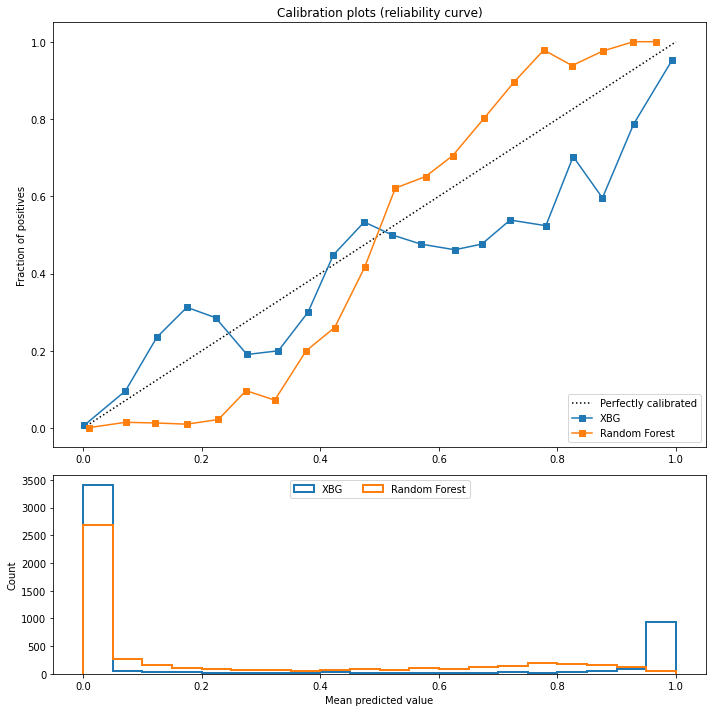

In [46]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(clf_xg2, 'XBG'),
                  (clf_rf2, 'Random Forest')]:
    clf.fit(x_train_encode, y_train_encode)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(x_test_encode)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(x_test_encode)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test_encode, prob_pos, n_bins=20)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()